PRUNING FILTERS FOR EFFICIENT CONVNETS (not in date with code)
===

**Reference**: https://arxiv.org/pdf/1608.08710.pdf

**Author**: `Minseong Kim` (tyui592@gmail.com)

### Imports

In [4]:
import os
os.environ['JUPYTER'] = 'True'
os.environ['JUPYTER_ARGS'] = '--action test --load-path ./pretrained_models/VGG16-CIFAR10-93%.pth'

import time
import numpy as np
import matplotlib.pyplot as plt

import torch

from utils import args
from utils.model import get_model
from procedures.evaluate import test_network
from procedures.prune import prune_network

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Pretrained Model Accuracy

In [2]:
test_network()

Files already downloaded and verified
Testing network (12.70), 	Accuracy: 93.65


### Graph the Normalized Absolute Sum of the Filter Weights
This is Figure 2 (a) of the paper.

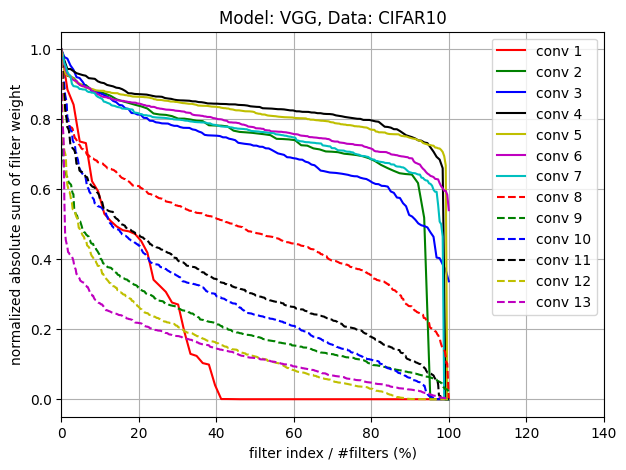

In [10]:
colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
lines = ['-', '--', '-.']
plt.figure(figsize=(7, 5))
conv_count = 0
model = get_model()
for layer in model.features:
    if isinstance(layer, torch.nn.Conv2d):
        line_style = colors[conv_count % len(colors)] + lines[conv_count // len(colors)]
        
        # Weights are out_ch x in_ch x k1 x k2
        fw = layer.weight.data.cpu().numpy()
        
        # Sort descending order
        sorted_abs_sum = np.sort(np.sum(np.abs(fw.reshape(fw.shape[0], -1)), axis=1))[::-1]
        
        # Normalize with maximum value
        normalized_abs_sum = sorted_abs_sum / sorted_abs_sum[0]
        conv_count += 1
        plt.plot(np.linspace(0, 100, normalized_abs_sum.shape[0]), normalized_abs_sum, line_style, label="conv %d" % conv_count)
        
plt.title("Model: %s, Data: %s" % (args.model, args.dataset))        
plt.ylabel("normalized absolute sum of filter weight")
plt.xlabel("filter index / #filters (%)")
plt.legend(loc='upper right')
plt.xlim([0, 140])
plt.grid()
plt.savefig("plots/figure1.png", dpi=150, bbox_inches='tight')
plt.show()        

### check: accuracy of the pruned network (Figure 2 (b) of the paper)

In [6]:
prune_step_ratio = 1/8
max_channel_ratio = 0.90 

prune_channels = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512]
prune_layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6', 'conv7', 'conv8', 'conv9', 'conv10', 'conv11', 'conv12', 'conv13']

check accuracy of the pruned network

In [7]:
top1_accuracies = {}
top5_accuracies = {}

for conv, channel in zip(prune_layers, prune_channels):    
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information
        args.prune_layers = [conv]
        args.prune_channels =[steps[i]]

        network = prune_network(args, network)
        
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 15:58:31 2019: Test information, Data(s): 1.112, Forward(s): 0.169, Top1: 93.470, Top5: 99.430, 

Wed Oct  2 15:58:31 2019: conv1 Layer, 8 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(56, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 15:58:38 2019: Test information, Data(s): 1.127, Forward(s): 0.170, Top1: 93.470, Top5: 99.430, 

Wed Oct  2 15:58:38 2019: conv1 Layer, 32 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 15:58:45 2019: Test information, Data(s): 1.110, Forward(s): 0.169, Top1: 92.670, Top5: 99.250, 

Wed Oct  2 15:58:45 2019: conv1 Layer, 57 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(in

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 15:58:56 2019: Test information, Data(s): 1.116, Forward(s): 0.168, Top1: 78.600, Top5: 96.460, 

Wed Oct  2 15:58:56 2019: conv2 Layer, 24 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(40, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 15:59:02 2019: Test information, Data(s): 1.125, Forward(s): 0.170, Top1: 39.830, Top5: 79.480, 

Wed Oct  2 15:59:02 2019: conv2 Layer, 48 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 15:59:13 2019: Test information, Data(s): 1.131, Forward(s): 0.172, Top1: 93.470, Top5: 99.430, 

Wed Oct  2 15:59:13 2019: conv3 Layer, 32 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(i

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 15:59:20 2019: Test information, Data(s): 1.130, Forward(s): 0.173, Top1: 87.990, Top5: 98.470, 

Wed Oct  2 15:59:20 2019: conv3 Layer, 82 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 46, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(i

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 15:59:27 2019: Test information, Data(s): 1.124, Forward(s): 0.172, Top1: 17.440, Top5: 57.590, 
-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 15:59:31 2019: Test information, Data(s): 1.106, Forward(s): 0.169, Top1: 93.470, Top5: 99.430, 

Wed Oct  2 15:59:31 2019: conv4 Layer, 16 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 15:59:38 2019: Test information, Data(s): 1.121, Forward(s): 0.171, Top1: 86.460, Top5: 97.740, 

Wed Oct  2 15:59:38 2019: conv4 Layer, 65 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 15:59:45 2019: Test information, Data(s): 1.122, Forward(s): 0.170, Top1: 25.980, Top5: 67.130, 

Wed Oct  2 15:59:45 2019: conv4 Layer, 115 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReL

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 15:59:56 2019: Test information, Data(s): 1.143, Forward(s): 0.173, Top1: 90.730, Top5: 98.600, 

Wed Oct  2 15:59:56 2019: conv5 Layer, 98 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:00:03 2019: Test information, Data(s): 1.118, Forward(s): 0.170, Top1: 53.610, Top5: 82.360, 

Wed Oct  2 16:00:03 2019: conv5 Layer, 197 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReL

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:00:13 2019: Test information, Data(s): 1.124, Forward(s): 0.170, Top1: 93.210, Top5: 99.290, 

Wed Oct  2 16:00:13 2019: conv6 Layer, 65 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:00:21 2019: Test information, Data(s): 1.128, Forward(s): 0.170, Top1: 83.520, Top5: 96.400, 

Wed Oct  2 16:00:21 2019: conv6 Layer, 164 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReL

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:00:28 2019: Test information, Data(s): 1.130, Forward(s): 0.171, Top1: 32.610, Top5: 80.760, 
-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:00:31 2019: Test information, Data(s): 1.107, Forward(s): 0.169, Top1: 93.470, Top5: 99.430, 

Wed Oct  2 16:00:31 2019: conv7 Layer, 32 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:00:38 2019: Test information, Data(s): 1.130, Forward(s): 0.171, Top1: 90.770, Top5: 99.080, 

Wed Oct  2 16:00:38 2019: conv7 Layer, 131 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReL

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:00:45 2019: Test information, Data(s): 1.122, Forward(s): 0.168, Top1: 66.680, Top5: 95.610, 

Wed Oct  2 16:00:45 2019: conv7 Layer, 230 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReL

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:00:56 2019: Test information, Data(s): 1.115, Forward(s): 0.169, Top1: 93.370, Top5: 99.300, 

Wed Oct  2 16:00:56 2019: conv8 Layer, 197 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReL

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:01:03 2019: Test information, Data(s): 1.117, Forward(s): 0.168, Top1: 91.180, Top5: 98.930, 

Wed Oct  2 16:01:03 2019: conv8 Layer, 394 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReL

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:01:14 2019: Test information, Data(s): 1.127, Forward(s): 0.170, Top1: 93.450, Top5: 99.430, 

Wed Oct  2 16:01:14 2019: conv9 Layer, 131 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReL

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:01:21 2019: Test information, Data(s): 1.119, Forward(s): 0.169, Top1: 93.430, Top5: 99.450, 

Wed Oct  2 16:01:21 2019: conv9 Layer, 328 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReL

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:01:28 2019: Test information, Data(s): 1.122, Forward(s): 0.170, Top1: 92.710, Top5: 99.310, 
-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:01:32 2019: Test information, Data(s): 1.127, Forward(s): 0.173, Top1: 93.470, Top5: 99.430, 

Wed Oct  2 16:01:32 2019: conv10 Layer, 65 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mod

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:01:39 2019: Test information, Data(s): 1.130, Forward(s): 0.171, Top1: 93.480, Top5: 99.430, 

Wed Oct  2 16:01:39 2019: conv10 Layer, 262 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Re

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:01:46 2019: Test information, Data(s): 1.122, Forward(s): 0.170, Top1: 93.410, Top5: 99.370, 

Wed Oct  2 16:01:46 2019: conv10 Layer, 460 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Re

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:01:57 2019: Test information, Data(s): 1.124, Forward(s): 0.170, Top1: 93.450, Top5: 99.420, 

Wed Oct  2 16:01:57 2019: conv11 Layer, 197 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Re

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:02:04 2019: Test information, Data(s): 1.126, Forward(s): 0.171, Top1: 93.430, Top5: 99.410, 

Wed Oct  2 16:02:04 2019: conv11 Layer, 394 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Re

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:02:14 2019: Test information, Data(s): 1.127, Forward(s): 0.169, Top1: 93.470, Top5: 99.430, 

Wed Oct  2 16:02:14 2019: conv12 Layer, 131 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Re

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:02:21 2019: Test information, Data(s): 1.117, Forward(s): 0.170, Top1: 93.500, Top5: 99.450, 

Wed Oct  2 16:02:21 2019: conv12 Layer, 328 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Re

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:02:28 2019: Test information, Data(s): 1.120, Forward(s): 0.169, Top1: 43.370, Top5: 88.970, 
-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:02:32 2019: Test information, Data(s): 1.108, Forward(s): 0.169, Top1: 93.470, Top5: 99.430, 

Wed Oct  2 16:02:32 2019: conv13 Layer, 65 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mod

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:02:39 2019: Test information, Data(s): 1.129, Forward(s): 0.172, Top1: 93.520, Top5: 99.450, 

Wed Oct  2 16:02:39 2019: conv13 Layer, 262 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Re

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:02:46 2019: Test information, Data(s): 1.128, Forward(s): 0.169, Top1: 66.960, Top5: 98.280, 

Wed Oct  2 16:02:46 2019: conv13 Layer, 460 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Re

plot accuracy graph

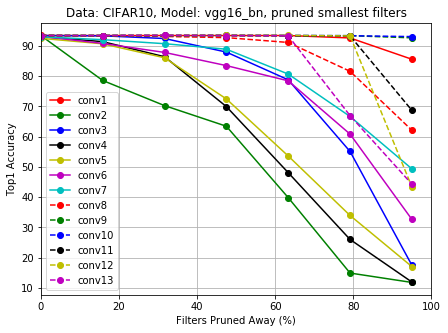

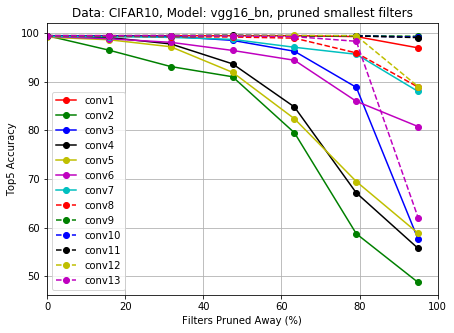

In [8]:
plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top1_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters"%(args.data_set, args.vgg))        
plt.ylabel("Top1 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("figure2_top1.png", dpi=150, bbox_inches='tight')
plt.show()                

plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top5_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters"%(args.data_set, args.vgg))        
plt.ylabel("Top5 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("figure2_top5.png", dpi=150, bbox_inches='tight')
plt.show()                

#### check: accuracy of retrained the pruned network (Figure 2 (c) of the paper)

In [9]:
args.retrain_flag = True
args.retrain_epoch = 10
args.independent_prune_flag = False
args.retrain_lr = 0.001

check accuracy of the retrained pruned network

In [ ]:
top1_accuracies = {}
top5_accuracies = {}

for conv, channel in zip(prune_layers, prune_channels):    
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information
        args.prune_layers = [conv]
        args.prune_channels =[steps[i]]

        network = prune_network(args, network)
        
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)

-*--*--*--*--*--*--*--*--*--*-
	Evalute network
-*--*--*--*--*--*--*--*--*--*-
Wed Oct  2 16:02:53 2019: Test information, Data(s): 1.108, Forward(s): 0.166, Top1: 93.470, Top5: 99.430, 

Wed Oct  2 16:02:53 2019: conv1 Layer, 8 Channels pruned
-*--*--*--*--*--*--*--*--*--*-
	Prune network
-*--*--*--*--*--*--*--*--*--*-
VGG(
  (features): Sequential(
    (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(56, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(

plot the accuracy graph

In [ ]:
plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top1_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters, retrain %d epochs"%(args.data_set, args.vgg, args.retrain_epoch))
plt.ylabel("Top1 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("figure3_top1.png", dpi=150, bbox_inches='tight')
plt.show()                

plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top5_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters, retrain %d epochs"%(args.data_set, args.vgg, args.retrain_epoch))
plt.ylabel("Top5 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("figure3_top5.png", dpi=150, bbox_inches='tight')
plt.show()                